In [2]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import time, itertools, numpy as np, xgboost as xgb,  pandas as pd, math, glob, json, operator, requests
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# Data Ingestion
# Ingest all 13 scenarios of the CTU-13 dataset
# Each Scenario is captured in a seperate pandas dataframe
capture_files = glob.glob("/home/fadi/jupyter/NEU/CTU-13-Dataset/*/capture*")
scenarios = {path.split("/")[-2]: pd.read_csv(path) for path in capture_files}

In [5]:
# Data Aggregation
# Aggregate all scenarios into one data frame
for scenario, data in scenarios.items():
    data["Scenario"] = scenario
ctu_13 = pd.concat(scenarios.values(), axis=0)
del scenarios

In [9]:
# Data Cleansing & Standardization
# Null/NaN Imputation
na_vals = {"Sport": -1, "Dport": -1, "State": "Missing", "sTos": -1, "dTos": -1}
ctu_13.fillna(na_vals, inplace=True)
# Convert Hex values of Sport, Dport to Integers
for col in ["Sport", "Dport"]:
    ctu_13[col] = ctu_13[col].apply(lambda x: int(x, 16) if type(x) == str else int(x))
# Parse "StartTime"
ctu_13["StartTime"] = pd.to_datetime(ctu_13["StartTime"], format="%Y/%m/%d %H:%M:%S.%f")

In [8]:
# Data Labelling
def labelling(x):
    if "background" in x.lower():
        return "Background"
    if "normal" in x.lower():
        return "Normal"
    if "botnet" in x.lower():
        return "Botnet"

ctu_13["Label"] = ctu_13["Label"].apply(labelling)

In [15]:
# Exploratory Data Analysis
# Distribution of Flow Types ( Background, Botnet, Normal ) across scenarios
scenario_stats = []
for scenario in range(1, 14):
    data = ctu_13[ctu_13["Scenario"] == str(scenario)]
    scenario_stat = {"Scenario": scenario, "Count": len(data)}
    label_stats = data.groupby("Label").count().to_dict()["Scenario"]
    print(label_stats)
    label_stats = {k:"%0.2f%%" % (v/scenario_stat["Count"]*100.0) for k,v in label_stats.items()}
    scenario_stat.update(label_stats)
    scenario_stats.append(scenario_stat)

all_stats = ctu_13.groupby("Label").count().to_dict()["Scenario"]
all_stats = {k:"%0.2f%%" % (v/len(ctu_13)*100.0) for k,v in all_stats.items()}
scenario_stats.append({**{"Scenario": "All", "Count": len(ctu_13)}, **all_stats})
pd.DataFrame(scenario_stats)

{'Background': 2753288, 'Botnet': 40961, 'Normal': 30387}
{'Background': 1778061, 'Botnet': 20941, 'Normal': 9120}
{'Background': 4566929, 'Botnet': 26822, 'Normal': 116887}
{'Background': 1093228, 'Botnet': 2580, 'Normal': 25268}
{'Background': 124252, 'Botnet': 901, 'Normal': 4679}
{'Background': 546795, 'Botnet': 4630, 'Normal': 7494}
{'Background': 112337, 'Botnet': 63, 'Normal': 1677}
{'Background': 2875281, 'Botnet': 6127, 'Normal': 72822}
{'Background': 1872554, 'Botnet': 184987, 'Normal': 29967}
{'Background': 1187592, 'Botnet': 106352, 'Normal': 15847}
{'Background': 96369, 'Botnet': 8164, 'Normal': 2718}
{'Background': 315675, 'Botnet': 2168, 'Normal': 7628}
{'Background': 1853207, 'Botnet': 40003, 'Normal': 31939}


,Scenario,Count,Background,Botnet,Normal
0,1,2824636,97.47%,1.45%,1.08%
1,2,1808122,98.34%,1.16%,0.50%
2,3,4710638,96.95%,0.57%,2.48%
3,4,1121076,97.52%,0.23%,2.25%
4,5,129832,95.70%,0.69%,3.60%
5,6,558919,97.83%,0.83%,1.34%
6,7,114077,98.47%,0.06%,1.47%
7,8,2954230,97.33%,0.21%,2.47%
8,9,2087508,89.70%,8.86%,1.44%
9,10,1309791,90.67%,8.12%,1.21%


In [16]:
# Exploratory Data Analysis
# Generic Distribution Analysis Function
def analyze(df, display_name, field, buckets=None, top=False):
    replaceNaN = field in na_vals
    if not buckets:
        uniq_vals = df[field].unique().tolist()
    if top:
        count_vals = sorted(ctu_13.groupby(field).count().to_dict()["Scenario"].items(), key=operator.itemgetter(1), reverse=True)
        count_vals = count_vals[:top]
        uniq_vals = [val[0] for val in count_vals]
    stats = {}
    for label, data in df.groupby("Label"):
        stats[label] = []
        count_label = len(data)
        if buckets:
            for name, bucket in buckets.items():
                stats[label].append(len(data[(data[field] >= bucket[0])&(data[field] < bucket[1])])/count_label)
        else:
            for uniq_val in uniq_vals:
                stats[label].append(len(data[data[field] == uniq_val])/count_label)

    # Plotting Results
    labels = buckets.keys() if buckets else uniq_vals
    labels = ["NaN" if ((val == -1) and replaceNaN) else val  for val in labels]
    x = np.arange(len(labels))
    col_width = 0.2
    fig, ax = plt.subplots(figsize=(15,5))
    rects_bg = ax.bar(x - col_width, stats["Background"], col_width, label="Background")
    rects_bn = ax.bar(x, stats["Botnet"], col_width, label="Botnet")
    rects_nr = ax.bar(x + col_width, stats["Normal"], col_width, label="Normal")
    ax.set_ylabel('% - Label')
    ax.set_xlabel(display_name)
    ax.set_title('%% By %s and Label' % display_name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

Background
                        StartTime       Dur Proto         SrcAddr   Sport  \
0      2011-08-15 17:13:51.499832  5.170088   tcp    2.157.248.25   12614   
1      2011-08-15 17:15:33.511251  6.609413   tcp  148.100.181.73  333416   
2      2011-08-15 17:20:00.189787  1.797185   tcp  61.177.250.153   29202   
3      2011-08-15 17:20:30.302882  1.959935   tcp  92.241.212.170  300336   
4      2011-08-15 17:20:32.262817  1.016078   tcp  92.241.212.170  300336   
...                           ...       ...   ...             ...     ...   
325466 2011-08-19 11:45:43.615033  0.000250   udp   147.32.84.138  268305   
325467 2011-08-19 11:45:43.615086  0.000290   udp   147.32.84.138  226305   
325468 2011-08-19 11:45:43.619933  0.000223   udp   147.32.84.138  336981   
325469 2011-08-19 11:45:43.619941  0.000279   udp   147.32.84.138  362904   
325470 2011-08-19 11:45:43.647861  0.000000   udp   147.32.84.229   78691   

          Dir        DstAddr   Dport  State  sTos  dTos  TotPkts

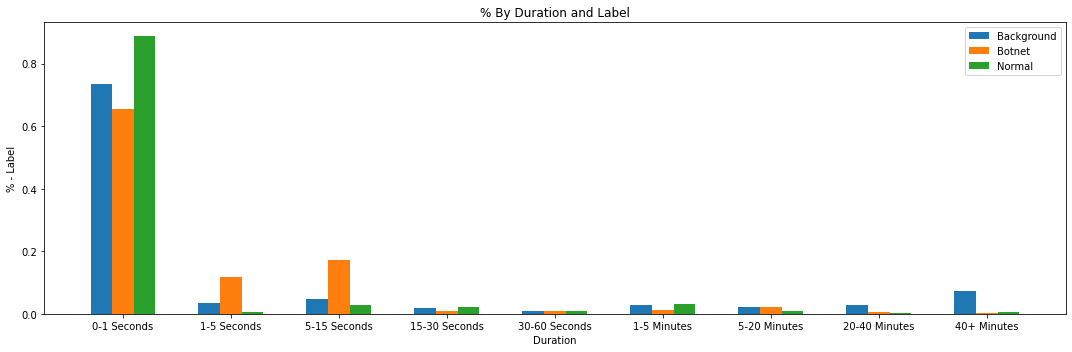

In [18]:
# Exploratory Data Analysis
# Duration - Flow Type
duration_buckets = {"0-1 Seconds": (0, 1), "1-5 Seconds": (1, 5), "5-15 Seconds": (5, 15), "15-30 Seconds": (15, 30), "30-60 Seconds": (30, 60), "1-5 Minutes": (60, 300), "5-20 Minutes": (300, 1200), "20-40 Minutes": (1200, 2400), "40+ Minutes": (2400, 9999)}
analyze(ctu_13, "Duration", "Dur", buckets=duration_buckets)

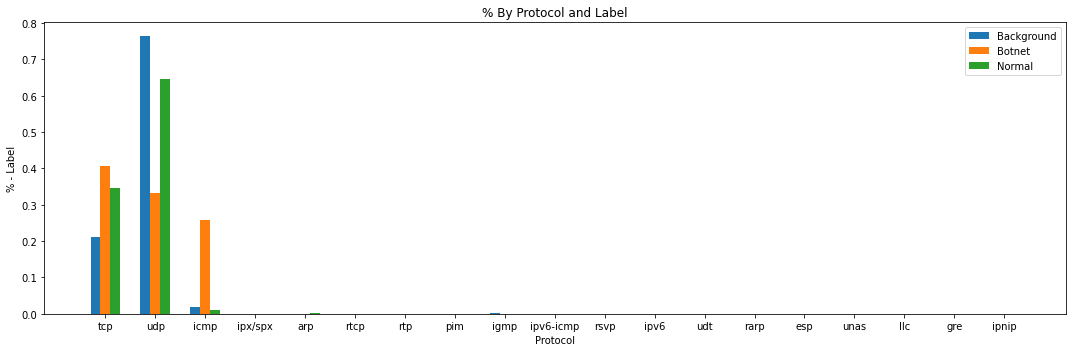

In [10]:
# Exploratory Data Analysis
# Protocol - Flow Type
analyze(ctu_13, "Protocol", "Proto")

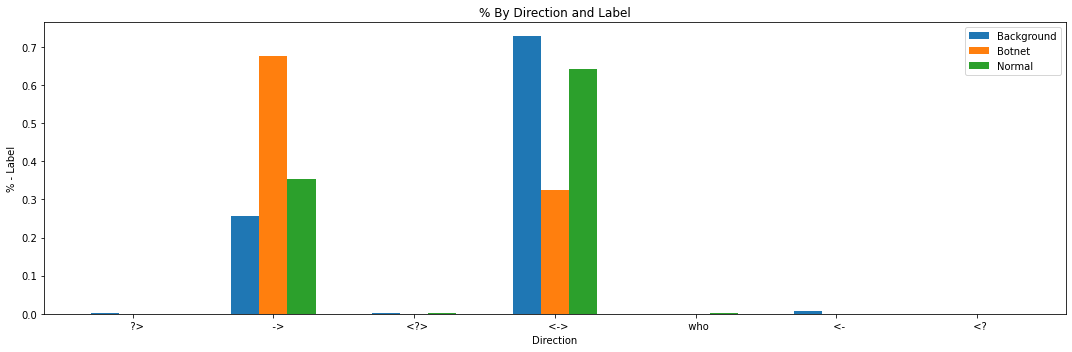

In [11]:
# Exploratory Data Analysis
# Direction - Flow Type
analyze(ctu_13, "Direction", "Dir")

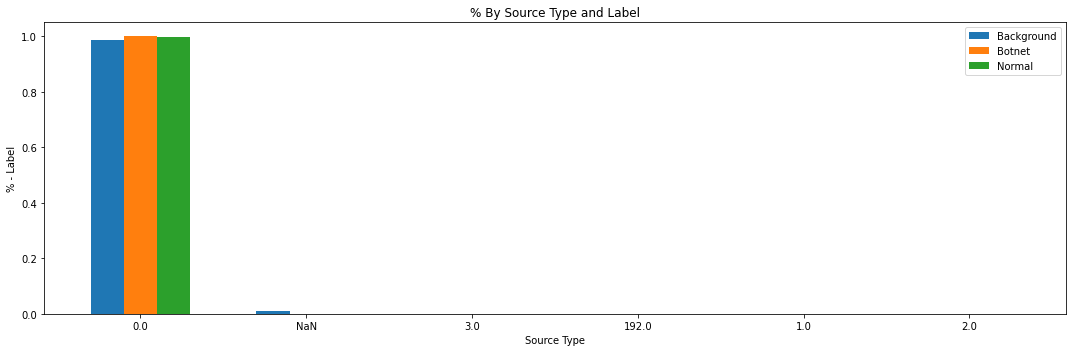

In [12]:
# Exploratory Data Analysis
# Source Type - Flow Type
analyze(ctu_13, "Source Type", "sTos")

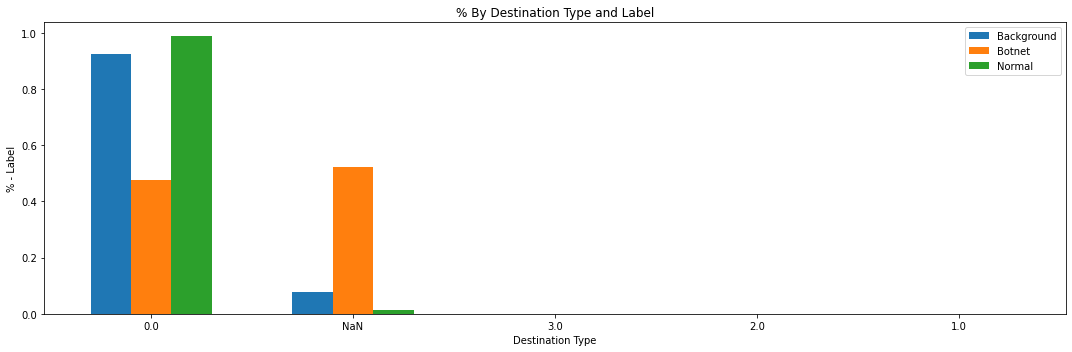

In [13]:
# Exploratory Data Analysis
# Destination Type - Flow Type
analyze(ctu_13, "Destination Type", "dTos")

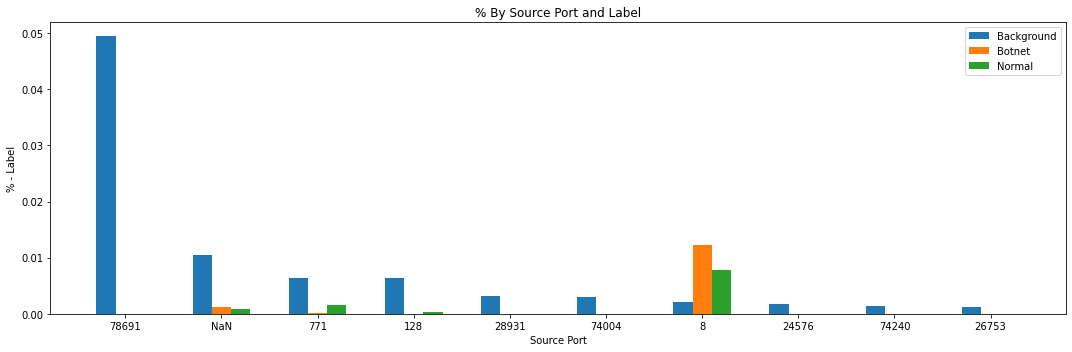

In [14]:
# Exploratory Data Analysis
# Source Port - Flow Type
analyze(ctu_13, "Source Port", "Sport", top=10)

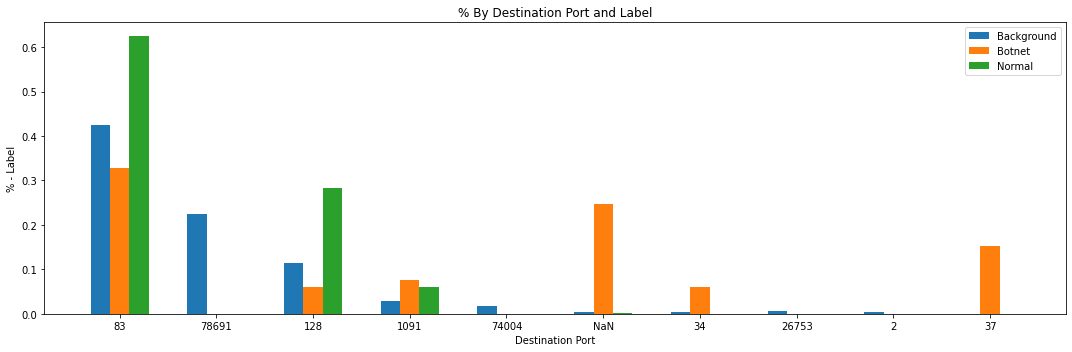

In [15]:
# Exploratory Data Analysis
# Destination Port - Flow Type
analyze(ctu_13, "Destination Port", "Dport", top=10)

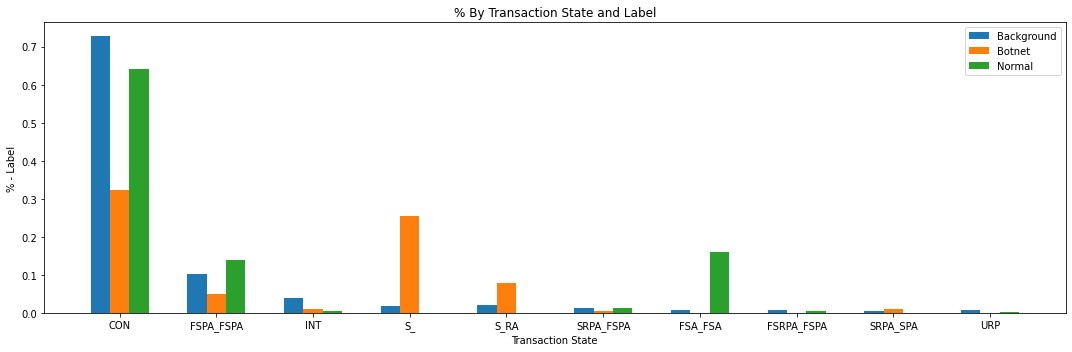

In [16]:
# Exploratory Data Analysis
# Transcation State - Flow Type
analyze(ctu_13, "Transaction State", "State", top=10)

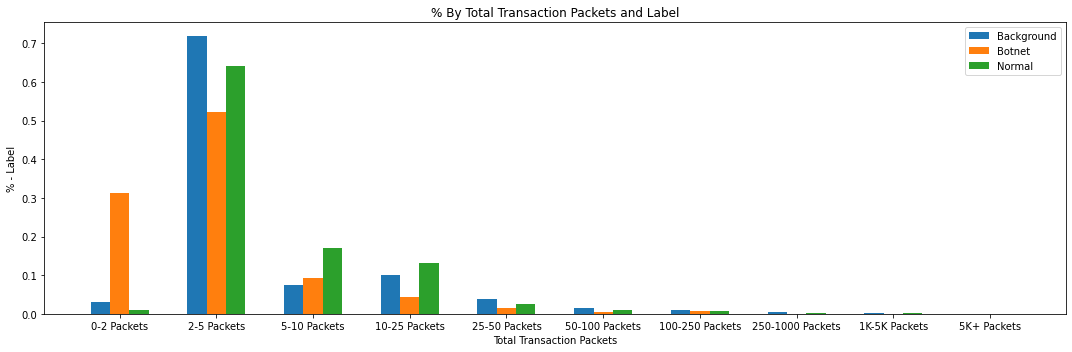

In [17]:
# Exploratory Data Analysis
# Total Transaction Packets - Flow Type
TotPkts_buckets = {"0-2 Packets": (0, 2), "2-5 Packets": (2, 5), "5-10 Packets": (5, 10), "10-25 Packets": (10, 25), "25-50 Packets": (25, 50), "50-100 Packets": (50, 100),  "100-250 Packets": (100, 250), "250-1000 Packets": (250, 1000), "1K-5K Packets": (1000, 5000), "5K+ Packets": (5000, 99999999)}
analyze(ctu_13, "Total Transaction Packets", "TotPkts", buckets=TotPkts_buckets)

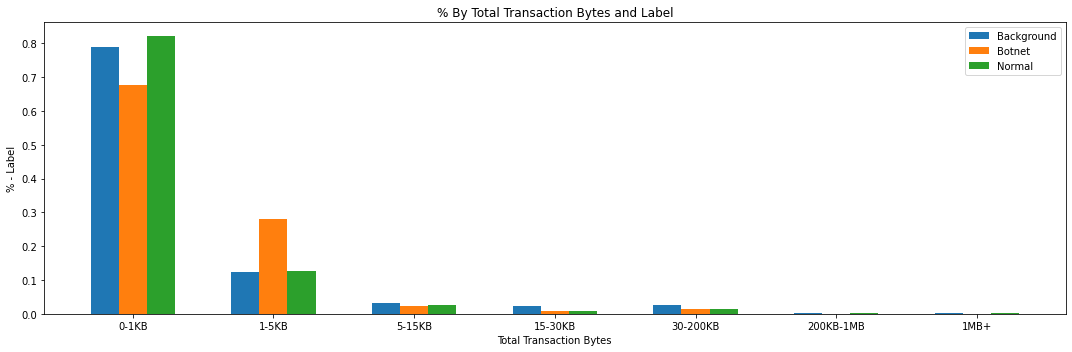

In [18]:
# Exploratory Data Analysis
# Total Transaction Bytes - Flow Type
TotBytes_buckets = {"0-1KB": (0, 1024), "1-5KB": (1024, 5*1024), "5-15KB": (5*1024, 15*1024), "15-30KB": (15*1024, 30*1024), "30-200KB": (30*1024, 200*1024), "200KB-1MB": (200*1024, 1024*1024), "1MB+": (1024*1024, 1024*1024*1024*1024)}
analyze(ctu_13, "Total Transaction Bytes", "TotBytes", buckets=TotBytes_buckets)

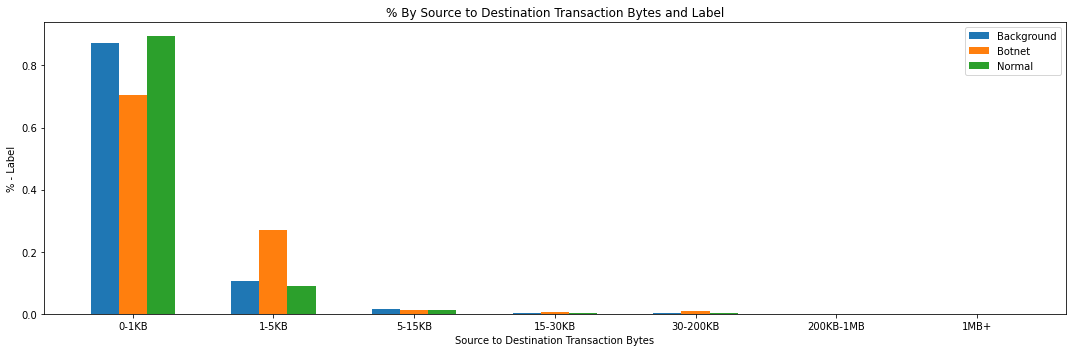

In [19]:
# Exploratory Data Analysis
# Source to Destination Transaction Bytes - Flow Type
SrcBytes_buckets = {"0-1KB": (0, 1024), "1-5KB": (1024, 5*1024), "5-15KB": (5*1024, 15*1024), "15-30KB": (15*1024, 30*1024), "30-200KB": (30*1024, 200*1024), "200KB-1MB": (200*1024, 1024*1024), "1MB+": (1024*1024, 1024*1024*1024*1024)}
analyze(ctu_13, "Source to Destination Transaction Bytes", "SrcBytes", buckets=SrcBytes_buckets)

In [20]:
# Feature Enrichment
# Extract City, Country from Source IP Address - [ on Hold - API blocked]
#uniq_ips = ctu_13["SrcAddr"].unique().tolist()
#requests.post("http://ip-api.com/batch", data=json.dumps(['114.33.245.44','212.93.105.52']))
# Extract hour of day (hod), day of week (dow), week of month (wom), month of year (moy)
ctu_13["hod"] = ctu_13["StartTime"].dt.hour
ctu_13["dow"] = ctu_13["StartTime"].apply(lambda x: x.weekday())
ctu_13["wom"] = ctu_13["StartTime"].dt.day//7 + 1
ctu_13["moy"] = ctu_13["StartTime"].dt.month
time_cols = ["hod", "dow", "wom", "moy"]

In [ ]:
# One Hot Encoding
ohe_in_cols = ["Proto", "Dir", "State", "sTos", "dTos"]
onehot_df = pd.get_dummies(ctu_13[ohe_in_cols])
ohe_out_cols = onehot_df.columns
ctu_13 = ctu_13.merge(onehot_df, left_index=True, right_index=True)
del onehot_df

In [21]:
# Scaling & Normalization
numerical_cols = ["Dur", "TotPkts", "TotBytes", "SrcBytes"]
scaler = StandardScaler()
ctu_13[numerical_cols] = scaler.fit_transform(ctu_13[numerical_cols])

In [22]:
# Label Encoding
def labelling(x):
    if x == "Background":
        return 0
    if x == "Normal":
        return 1
    if x == "Botnet":
        return 2
ctu_13["Label"] = ctu_13["Label"].apply(labelling)

In [29]:
# Model Build
feature_cols = numerical_cols + time_cols #+ ohe_out_cols
results = []
for scenario, data in ctu_13.groupby("Scenario"):
    x = data[feature_cols].values
    y = data["Label"].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model = xgb.XGBClassifier(objective='multi:softprob', eval_metric="mlogloss") 
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    f1 = f1_score(y_test, predictions, average="weighted")
    recall = recall_score(y_test, predictions, average="weighted")
    precision = precision_score(y_test, predictions, average="weighted")
    results.append({"Scenario": int(scenario), "f1_score": f1, "Recall": recall, "Precision":  precision})
pd.DataFrame(results).sort_values("Scenario")

,Scenario,f1_score,Recall,Precision
0,1,0.986029,0.987489,0.986262
5,2,0.994325,0.994425,0.994259
6,3,0.996500,0.996548,0.996505
7,4,0.979301,0.982280,0.979718
8,5,0.961714,0.968383,0.964219
9,6,0.987930,0.989337,0.988019
10,7,0.984427,0.987509,0.986676
11,8,0.985587,0.986812,0.986227
12,9,0.963030,0.965298,0.963366
1,10,0.991574,0.992323,0.991477
